# Voting Ensemble Classifier

## Library Imports

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from scipy import stats

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, auc, roc_auc_score, roc_curve, log_loss, plot_roc_curve
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_validate, cross_val_score, cross_val_predict, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, SGDClassifier, SGDRegressor, LassoLars, BayesianRidge 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier, VotingRegressor, GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
import sklearn.gaussian_process as gp
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

%matplotlib inline
sns.set(color_codes=True)

## Dataset Imports

In [2]:
# The latest version of processed training data
trainCleaned = "dataset/two-sigma-connect-rental-listing-inquiries/trainTextExtract.json.zip"
trainData = pd.read_json(trainCleaned, convert_dates=['created'])

# Processed test data
testDataDir = "dataset/two-sigma-connect-rental-listing-inquiries/testTextExtract.json.zip"
testData = pd.read_json(testDataDir, convert_dates=['created'])

# trainData.head(5)
# trainData.columns

## Choosing features for prediction

The features listed should be necessary for prediction <br/>
- Bathrooms<br/>
Reason: Interest levels depends on the number of bathrooms a listing has  
- Bedrooms<br/>
Reason: Interest levels depends on the number of bedrooms a listing has
- Price <br/>
Reason: Interest levels depends on the listing price
- Year, Month, Day<br/>
Reason: if the user is planning to move out to another location within a specific date/time-frame, interest may be higher
- Number of Photos<br/>
Reason: the number of photos in a listing may correlate well with the interest levels
- Description Word Count (desc_word_count)<br/>
Reason: descriptions with more words could mean very detailed description which lead to higher interest
- Description Average Word Length(desc_avg_word_length)<br/>
Reason: large average word length could mean very detailed description which lead to higher interest
- Number of features (num_features)<br/>
Reason: more features within a listing could lead to more interest
- Latitude + Longitude <br/>
Reason: interest could be higher on specific area of New York

In [3]:
features = ['bathrooms', 'bedrooms', 'price', 'year', 'month', 'day', 'num_photos', 'desc_word_count', 'desc_avg_word_length', 'num_features', 'latitude', 'longitude']
X = trainData[features]
testX = testData[features]

# display(X.head(5))
# display(testData.iloc[1])

## Label Encoding: transform target variable to binary codes

In [4]:
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
le = LabelEncoder()
target = trainData[['interest_level']]
y = le.fit_transform(target['interest_level'])
# display(y)

# Alternative
# target = trainData[['interest_level']].astype('category')
# y = target['interest_level'].cat.codes

## Voting Ensemble Classifier
### Notes


### Original Model: Initialization, Training, Testing

Training: Evaluate model using log loss

Testing: Output prediction probabilities for test dataset

References:
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
- https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html
- https://towardsdatascience.com/quick-start-to-gaussian-process-regression-36d838810319
- https://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html
- https://scikit-learn.org/stable/modules/ensemble.html#voting-regressor
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression


#### Building and Training the Model with Cross-Validation

In [5]:
gNB = GaussianNB()
logreg = LogisticRegression(solver='lbfgs', max_iter=5000, multi_class='multinomial')
gboost = GradientBoostingClassifier(n_estimators=25)
rf = RandomForestClassifier(n_estimators=50)
# sgd = SGDClassifier(loss='log', max_iter=5000)
knn = KNeighborsClassifier(n_neighbors=7)
# svc = SVC(kernel='rbf', C=0.1, probability=True)

model = VotingClassifier(
    estimators=[('nb', gNB), ('lr', logreg), ('gb', gboost), ('rf', rf), ('knn', knn)],
    voting='soft')

model.fit(X, y)
print(model.score(X, y))

0.7739791943540626


In [6]:
# Regressor Model

# kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
# gpreg = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
linreg = LinearRegression()
gbreg = GradientBoostingRegressor(random_state=1, n_estimators=10)
rfreg = RandomForestRegressor(random_state=1, n_estimators=23)
# sgdreg = SGDRegressor(max_iter=1000, tol=1e-3)
llars = LassoLars(alpha=0.01)
br = BayesianRidge()

# model_reg = VotingRegressor(estimators=[('rf', rfreg), ('gb', gbreg)])
# model_reg = VotingRegressor(estimators=[('rf', rfreg), ('gb', gbreg), ('lr', linreg)])
model_reg = VotingRegressor(estimators=[('rf', rfreg), ('gb', gbreg), ('br', br), ('ll', llars)])

model_reg.fit(X, y)
print(model_reg.score(X, y))

0.3075004377972025


In [7]:
# Quick CV run & scoring
cv_scores = cross_val_score(model, X, y, cv=3)
print("Accuracy scores:", cv_scores)
print("Mean accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

Accuracy scores: [0.65967831 0.66701038 0.66879769]
Mean accuracy: 0.67 (+/- 0.01)


In [10]:
# Expanded CV runs & scoring
cv_LL = []
accuracy_scores = []
kf = StratifiedKFold(n_splits=5, shuffle=True)
for train_index, val_index in kf.split(X, y):
    X_train, X_val = X.iloc[train_index,:], X.iloc[val_index,:]
    y_train, y_val = y[train_index], y[val_index]
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_val)
    y_pred = model.predict(X_val)
    cv_LL.append(log_loss(y_val, y_pred_prob))
    accuracy_scores.append(model.score(X_val, y_val))
    print(classification_report(y_val, y_pred))
    
print("Log-loss:", cv_LL, "\nMean log-loss:", np.mean(cv_LL))
print("Accuracy scores:", accuracy_scores, "\nMean accuracy:", np.mean(accuracy_scores))

              precision    recall  f1-score   support

           0       0.61      0.11      0.19       728
           1       0.70      0.97      0.82      5858
           2       0.45      0.10      0.17      2143

    accuracy                           0.69      8729
   macro avg       0.59      0.40      0.39      8729
weighted avg       0.63      0.69      0.60      8729

              precision    recall  f1-score   support

           0       0.65      0.12      0.20       729
           1       0.70      0.97      0.81      5858
           2       0.45      0.10      0.16      2142

    accuracy                           0.69      8729
   macro avg       0.60      0.40      0.39      8729
weighted avg       0.63      0.69      0.60      8729

              precision    recall  f1-score   support

           0       0.62      0.09      0.16       728
           1       0.70      0.97      0.81      5858
           2       0.44      0.11      0.17      2142

    accuracy        

#### Testing the Model

In [12]:
# Test the prediction probabilities based on the trained model

predictions = model.predict_proba(testX)
pred_df = pd.DataFrame(predictions)
pred_df.columns = le.classes_
pred_df["listing_id"] = testData.listing_id.values
pred_df.set_index('listing_id', inplace=True)
pred_df.sort_index(inplace=True)

display(pred_df)
pred_df.to_csv("voting_original.csv")

,high,low,medium
listing_id,,,
6811958,0.160195,0.541655,0.298150
6811960,0.020794,0.791992,0.187214
6811964,0.079446,0.636419,0.284135
6811971,0.042210,0.693692,0.264098
6811974,0.158831,0.435243,0.405927
...,...,...,...
7748251,0.020559,0.797287,0.182154
7748271,0.086231,0.548133,0.365635
7748273,0.363174,0.369648,0.267179


### Original Model: Evaluation (Accuracy & Overfitting Dectection)

#### ROC Curve
References:
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#plot-roc-curves-for-the-multilabel-problem
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

ValueError: VotingClassifier should be a binary classifer

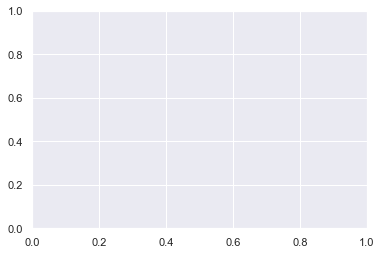

In [11]:
# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
 
#---

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

#### Learning Curves

In [ ]:
# train_errors = [] # Log training errors for each model
# test_errors = [] # Log testing errors for each model

# X_train, X_test, y_train, y_test = train_test_split(X, y)

# for x in max_depth_list:
#     model = tree.DecisionTreeClassifier(max_depth=x) 
#     model.fit(X_train,y_train)
#     train_errors.append(model.score(X_train, y_train))
#     test_errors.append(model.score(X_test, y_test))

# x = np.arange(len(max_depth_list)) + 1 # Create domain for plot
# plt.figure(figsize=(20,10))
# plt.xticks(x)
# plt.plot(x, train_errors, label='Training Accuracy') # Plot training error over domain
# plt.plot(x, test_errors, label='Testing Accuracy') # Plot testing error over domain
# plt.xlabel('Maximum Tree Depth') # Label x-axis
# plt.ylabel('Model Accuracy') # Label y-axis
# plt.legend() # Show plot labels as legend
# plt.plot() # Show graph

References: 
- https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score

## Improvements: parameter tuning

In [27]:
gNB = GaussianNB()
logreg = LogisticRegression(solver='lbfgs', max_iter=5000, multi_class='multinomial', C=0.8)
gboost = GradientBoostingClassifier(n_estimators=50)
rf = RandomForestClassifier(n_estimators=70, max_depth=None, max_features=None, min_samples_leaf=10, min_samples_split=2)
# sgd = SGDClassifier(loss='log', max_iter=5000)
knn = KNeighborsClassifier(n_neighbors=9)
# svc = SVC(kernel='rbf', C=0.1, probability=True)

model_2 = VotingClassifier(
    estimators=[('nb', gNB), ('lr', logreg), ('gb', gboost), ('rf', rf), ('knn', knn)],
    voting='soft',
    weights=[1,3,2,4,2])

# model_2 = make_pipeline(
#     PCA(5),
#     vcl
# )

model_2.fit(X, y)
print(model_2.score(X, y))

0.7362861463727601


In [28]:
cv_LL = []
accuracy_scores = []
kf = StratifiedKFold(n_splits=5, shuffle=True)
for train_index, val_index in kf.split(X, y):
    X_train, X_val = X.iloc[train_index,:], X.iloc[val_index,:]
    y_train, y_val = y[train_index], y[val_index]
    model_2.fit(X_train, y_train)
    y_pred_prob = model_2.predict_proba(X_val)
    y_pred = model_2.predict(X_val)
    cv_LL.append(log_loss(y_val, y_pred_prob))
    accuracy_scores.append(model_2.score(X_val, y_val))
    print(classification_report(y_val, y_pred))
    
print("Log-loss:", cv_LL, "\nMean log-loss:", np.mean(cv_LL))
print("Accuracy scores:", accuracy_scores, "\nMean accuracy:", np.mean(accuracy_scores))

              precision    recall  f1-score   support

           0       0.69      0.12      0.20       728
           1       0.71      0.97      0.82      5858
           2       0.43      0.12      0.19      2143

    accuracy                           0.69      8729
   macro avg       0.61      0.40      0.40      8729
weighted avg       0.64      0.69      0.61      8729

              precision    recall  f1-score   support

           0       0.62      0.12      0.21       729
           1       0.71      0.98      0.82      5858
           2       0.49      0.12      0.19      2142

    accuracy                           0.69      8729
   macro avg       0.61      0.41      0.41      8729
weighted avg       0.65      0.69      0.61      8729

              precision    recall  f1-score   support

           0       0.65      0.14      0.22       728
           1       0.71      0.97      0.82      5858
           2       0.47      0.12      0.20      2142

    accuracy        

In [29]:
# Test the prediction probabilities based on the trained model

predictions = model_2.predict_proba(testX)
pred_df = pd.DataFrame(predictions)
pred_df.columns = le.classes_
pred_df["listing_id"] = testData.listing_id.values
pred_df.set_index('listing_id', inplace=True)
pred_df.sort_index(inplace=True)

display(pred_df)
pred_df.to_csv("voting_improved.csv")

,high,low,medium
listing_id,,,
6811958,0.083128,0.538321,0.378551
6811960,0.026869,0.847864,0.125267
6811964,0.086759,0.644379,0.268862
6811971,0.031364,0.723381,0.245254
6811974,0.167145,0.411796,0.421059
...,...,...,...
7748251,0.026799,0.707835,0.265366
7748271,0.097838,0.568044,0.334118
7748273,0.240259,0.464553,0.295188
